In [1]:
from utils.config import Config
from model.fasterrcnn import FasterRCNNTrainer, FasterRCNN
import tensorflow as tf
from utils.data import Dataset
import matplotlib.pyplot as plt

In [2]:
from model.fasterrcnn import _fast_rcnn_loc_loss

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
%matplotlib notebook

In [5]:
config = Config()
config._parse({})

======user config========
{'max_size': 1000,
 'min_size': 600,
 'voc_data_dir': 'D:/DataClinic/simple-faster-rcnn-pytorch/VOCdevkit/VOC2007/'}
==========end============


In [6]:
dataset = Dataset(config)

In [7]:
VOC_BBOX_LABEL_NAMES = (
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',
    'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',
    'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')


In [10]:
frcnn = FasterRCNN(21, (7, 7))
model = FasterRCNNTrainer(frcnn)
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
# 相当于build一下模型
img, bboxes, labels, scale = dataset[1]
bboxes = tf.cast(bboxes, dtype=tf.float32)
labels = tf.cast(labels, dtype=tf.float32)

_, _, _, _ = model(img, bboxes, labels, scale)
# 然后就能载入权重了
model.load_weights('frcnn.h5')

In [115]:
img, bboxes, labels, scale = dataset[1]
bboxes = tf.cast(bboxes, dtype=tf.float32)
labels = tf.cast(labels, dtype=tf.float32)
img_size = img.shape[1:3]

In [91]:
feature_map = model.faster_rcnn.extractor(img)
rpn_locs, rpn_scores, rois, anchor = model.faster_rcnn.rpn(feature_map, img_size, scale)

这是训练一段时间后的

In [17]:
for x in (feature_map, rpn_locs, rpn_scores, rois, anchor):
    print('shape:', x.shape, 'max:', tf.reduce_max(x).numpy(), 'min:', tf.reduce_min(x).numpy())

shape: (1, 38, 57, 512) max: 3.7585986 min: 0.0
shape: (1, 19494, 4) max: 4.816681 min: -3.6117132
shape: (1, 19494, 2) max: 6.432135 min: -7.866268
shape: (1220, 4) max: 900.0 min: 0.0
shape: (19494, 4) max: 1266.0387 min: -354.03867


In [18]:
gt_rpn_loc, gt_rpn_label = model.anchor_target_creator(bboxes, anchor, img_size)

In [19]:
# 这个对于每一张图是固定的，和训练了多久无关。
for x in (gt_rpn_loc, gt_rpn_label):
    print('shape:', x.shape, 'max:', tf.reduce_max(x).numpy(), 'min:', tf.reduce_min(x).numpy())

shape: (19494, 4) max: 5.735298 min: -2.9267602
shape: (19494,) max: 1 min: -1


In [20]:
x = gt_rpn_loc[gt_rpn_label != -1]
print('shape:', x.shape, 'max:', tf.reduce_max(x).numpy(), 'min:', tf.reduce_min(x).numpy())

shape: (256, 4) max: 5.5585217 min: -2.9267602


这是训练一段时间后的

In [22]:
_fast_rcnn_loc_loss(conv_cls_bboxes, gt_rpn_loc, gt_rpn_label, 3.0)

<tf.Tensor: shape=(), dtype=float32, numpy=0.00077042665>

In [23]:
from utils.data import vis

<IPython.core.display.Javascript object>


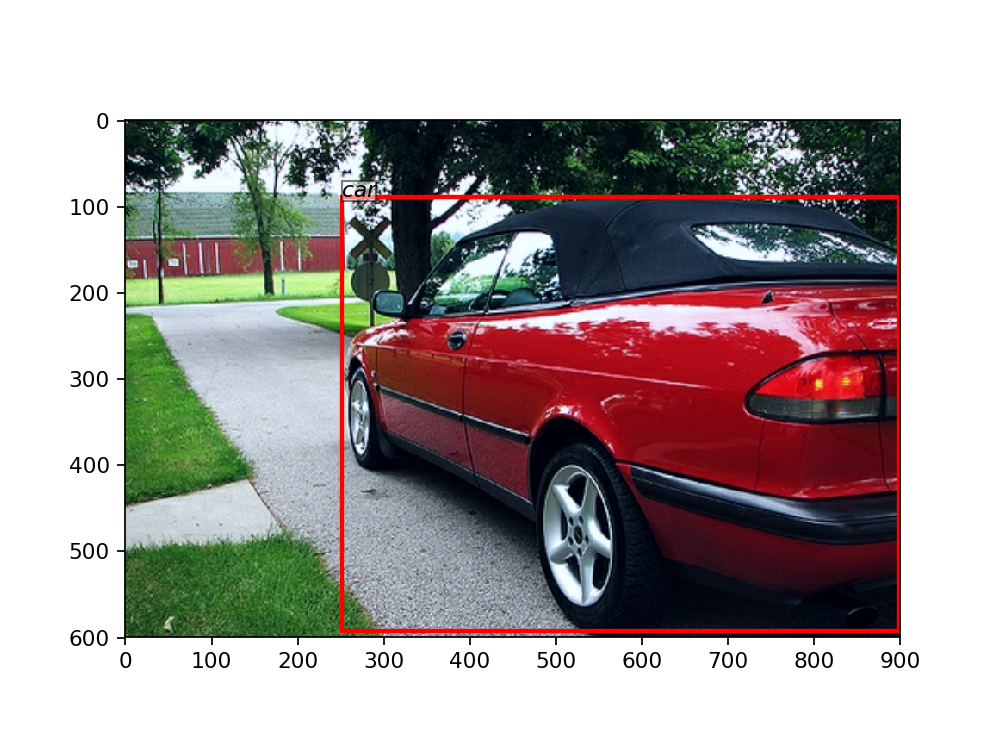

W0705 18:08:36.637315  1104 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [27]:
vis(img[0], bboxes, labels)

In [34]:
training_index = gt_rpn_label != -1

assert len(gt_rpn_loc[training_index]) == 256

training_anchor = anchor[training_index]
training_rpn_locs = tf.reshape(rpn_locs,[-1, 4])[training_index]
training_rpn_scores = tf.reshape(rpn_scores,[-1, 2])[training_index]

训练一段时候

In [35]:
for x in (training_anchor, training_conv_cls_bboxes, training_rpn_scores):
    print('shape:', x.shape, 'max:', tf.reduce_max(x).numpy(), 'min:', tf.reduce_min(x).numpy())

shape: (256, 4) max: 898.50964 min: 2.980667
shape: (256, 4) max: 3.1795309 min: -3.533154
shape: (256, 2) max: 6.3058696 min: -7.686414


In [144]:
img = (img[0] * 0.225) + 0.45
img = img.numpy()

In [32]:
from utils.anchor import loc2bbox

In [39]:
rpn_locs = tf.reshape(rpn_locs, [-1,4]).numpy()
rpn_bbox = loc2bbox(anchor, rpn_locs)

<IPython.core.display.Javascript object>


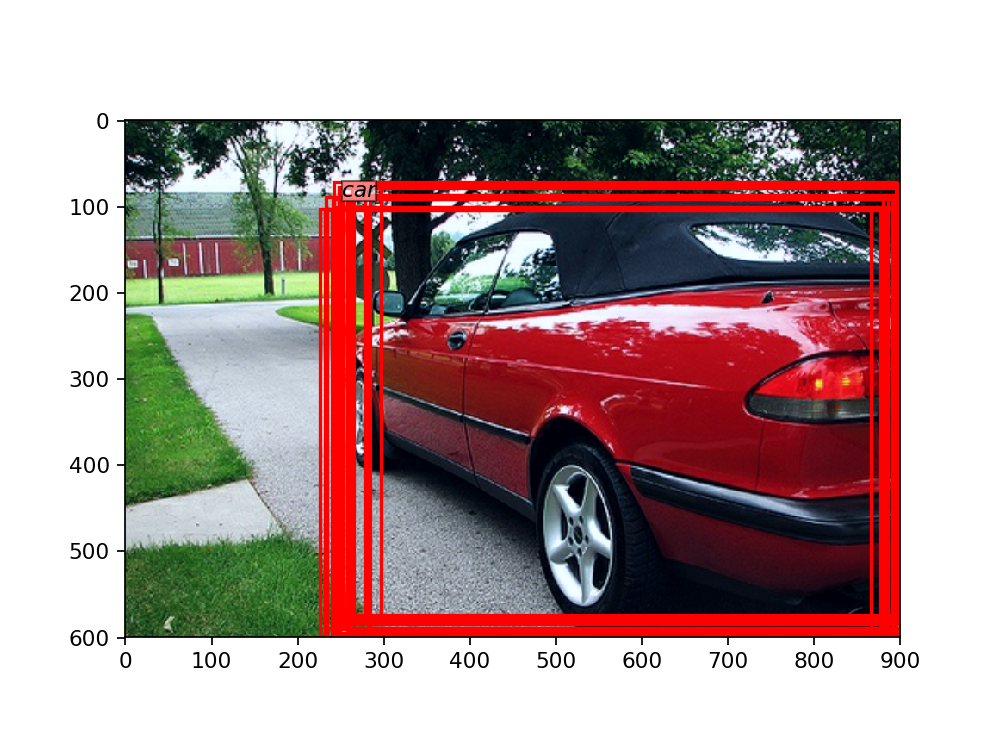

W0705 18:15:30.544834  1104 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


"\nneg_rpn_bbox = rpn_bbox[gt_rpn_label == 0]\nfor i in range(len(neg_anchor)):\n    y1 = neg_rpn_bbox[i][0]\n    x1 = neg_rpn_bbox[i][1]\n    y2 = neg_rpn_bbox[i][2]\n    x2 = neg_rpn_bbox[i][3]\n    height = y2 - y1\n    width = x2 - x1\n    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='green', linewidth=0.4))\n"

In [41]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img)

for i in range(len(bboxes)):
    y1 = bboxes[i][0]
    x1 = bboxes[i][1]
    y2 = bboxes[i][2]
    x2 = bboxes[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='yellow', linewidth=2))
    ax.text(x1,y1,VOC_BBOX_LABEL_NAMES[labels[i]],style='italic',bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 0})

pos_rpn_bbox = rpn_bbox[gt_rpn_label == 1]
for i in range(len(pos_rpn_bbox)):
    y1 = pos_rpn_bbox[i][0]
    x1 = pos_rpn_bbox[i][1]
    y2 = pos_rpn_bbox[i][2]
    x2 = pos_rpn_bbox[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='red', linewidth=1.5))

'''
neg_rpn_bbox = rpn_bbox[gt_rpn_label == 0]
for i in range(len(neg_anchor)):
    y1 = neg_rpn_bbox[i][0]
    x1 = neg_rpn_bbox[i][1]
    y2 = neg_rpn_bbox[i][2]
    x2 = neg_rpn_bbox[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='green', linewidth=0.4))
'''

In [42]:
rpn_target_bbox = loc2bbox(anchor, gt_rpn_loc)

<IPython.core.display.Javascript object>


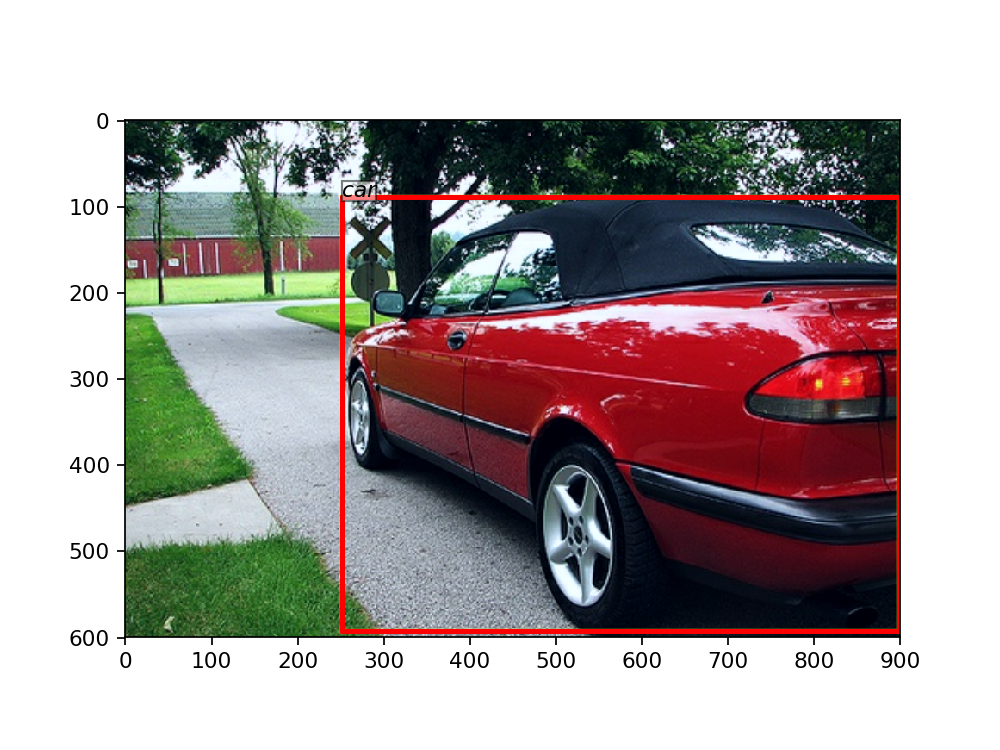

W0705 18:18:40.676460  1104 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [44]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img)

for i in range(len(bboxes)):
    y1 = bboxes[i][0]
    x1 = bboxes[i][1]
    y2 = bboxes[i][2]
    x2 = bboxes[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='yellow', linewidth=2))
    ax.text(x1,y1,VOC_BBOX_LABEL_NAMES[labels[i]],style='italic',bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 0})

pos_rpn_target_bbox = rpn_target_bbox[gt_rpn_label == 1]
for i in range(len(pos_rpn_target_bbox)):
    y1 = pos_rpn_target_bbox[i][0]
    x1 = pos_rpn_target_bbox[i][1]
    y2 = pos_rpn_target_bbox[i][2]
    x2 = pos_rpn_target_bbox[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='red', linewidth=1.5))

In [45]:
gt_rpn_label[training_index]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [46]:
rpn_scores[0][training_index]

<tf.Tensor: shape=(256, 2), dtype=float32, numpy=
array([[ 4.5017796, -5.332042 ],
       [ 4.615132 , -5.4467635],
       [ 4.636897 , -6.8888464],
       [ 4.109133 , -6.066575 ],
       [ 4.554851 , -5.4056306],
       [ 4.5593724, -5.39186  ],
       [ 4.681708 , -6.9494863],
       [ 4.7460427, -7.067083 ],
       [ 4.3741183, -6.449654 ],
       [ 4.4944696, -5.322836 ],
       [ 4.4783583, -6.523541 ],
       [ 5.1349096, -6.1163673],
       [ 3.9221964, -5.775815 ],
       [ 4.9366975, -5.829161 ],
       [ 4.2137127, -6.145561 ],
       [ 5.3895874, -6.3554688],
       [ 5.186748 , -6.0968575],
       [ 4.3575478, -6.4326987],
       [ 4.679576 , -6.7646666],
       [ 4.3571863, -5.4884696],
       [ 4.899416 , -5.8097596],
       [ 5.4346566, -4.8677955],
       [ 5.1061997, -5.996177 ],
       [ 5.4159803, -4.8401794],
       [ 3.9918342, -5.8974204],
       [ 4.2821803, -6.330407 ],
       [ 5.1666636, -6.1367035],
       [ 4.3680816, -6.4714904],
       [ 4.3801756, -6.489

In [48]:
tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)(gt_rpn_label[training_index], rpn_scores[0][training_index])

<tf.Tensor: shape=(), dtype=float32, numpy=1.1920928e-07>

In [49]:
rois.shape

(1220, 4)

In [50]:
rois[0]

array([ 40.240814, 550.94305 , 557.65234 , 900.      ], dtype=float32)

<IPython.core.display.Javascript object>


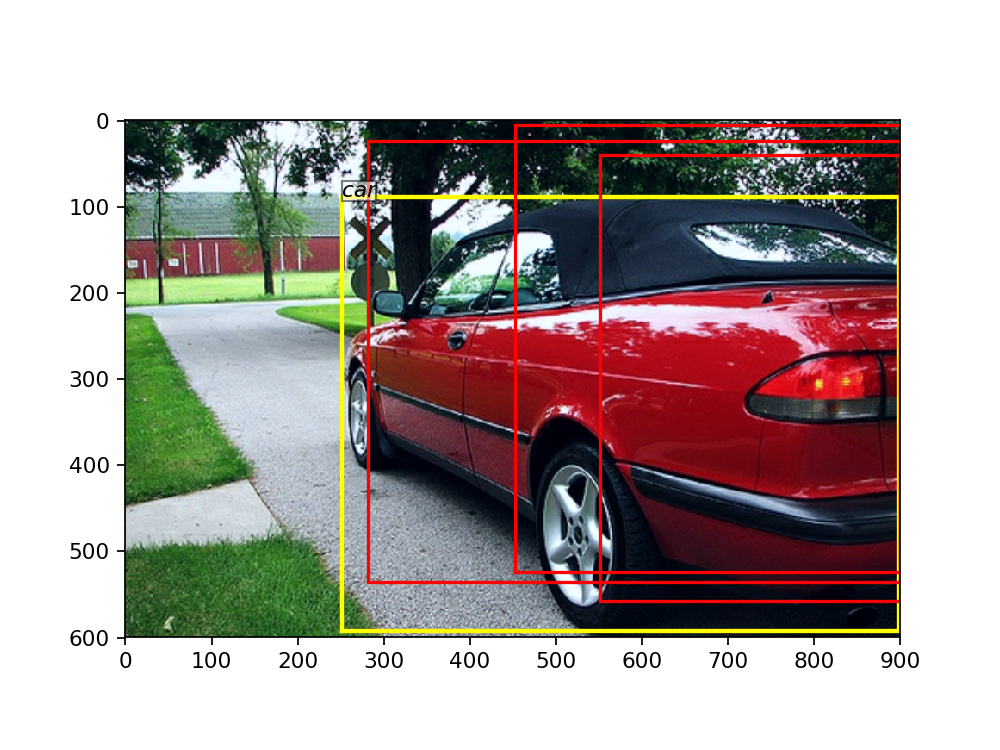

W0705 18:28:48.156744  1104 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [83]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img)

for i in range(len(bboxes)):
    y1 = bboxes[i][0]
    x1 = bboxes[i][1]
    y2 = bboxes[i][2]
    x2 = bboxes[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='yellow', linewidth=2))
    ax.text(x1,y1,VOC_BBOX_LABEL_NAMES[labels[i]],style='italic',bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 0})


for i in range(3):
    y1 = rois[i][0]
    x1 = rois[i][1]
    y2 = rois[i][2]
    x2 = rois[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='red', linewidth=1.5))

In [84]:
roi[:3]

array([[ 40.240814, 550.94305 , 557.65234 , 900.      ],
       [  4.940094, 451.90372 , 523.87537 , 900.      ],
       [ 23.142334, 281.23285 , 535.75085 , 900.      ]], dtype=float32)

In [116]:
rpn_score = rpn_scores[0]
rpn_loc = rpn_locs[0]

sample_roi, gt_roi_loc, gt_roi_label = model.proposal_target_creator(rois, bboxes.numpy(), labels.numpy())
roi_cls_loc, roi_score = model.faster_rcnn.head(feature_map, sample_roi, img_size)

<IPython.core.display.Javascript object>


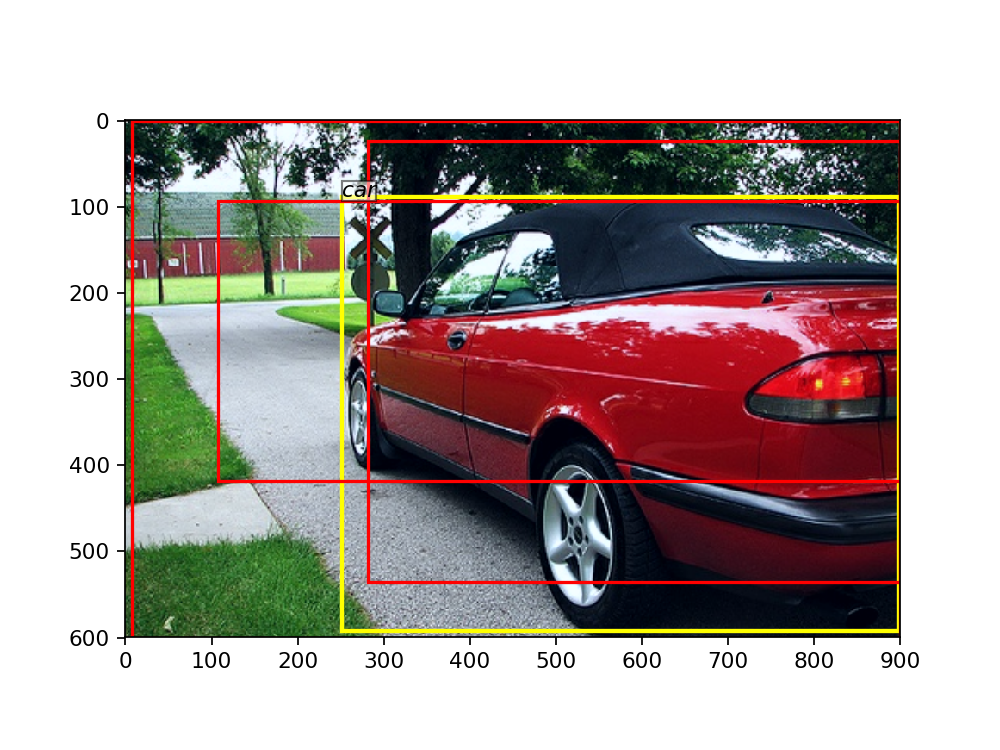

W0705 18:35:26.510817  1104 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [99]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img)
_, bboxes, labels, scale = dataset[1]

for i in range(len(bboxes)):
    y1 = bboxes[i][0]
    x1 = bboxes[i][1]
    y2 = bboxes[i][2]
    x2 = bboxes[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='yellow', linewidth=2))
    ax.text(x1,y1,VOC_BBOX_LABEL_NAMES[labels[i]],style='italic',bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 0})


for i in range(3):
    y1 = sample_roi[i][0]
    x1 = sample_roi[i][1]
    y2 = sample_roi[i][2]
    x2 = sample_roi[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='red', linewidth=1.5))

In [101]:
sample_roi[:3]

array([[ 92.60419 , 107.24451 , 418.4668  , 900.      ],
       [  0.      ,   7.577057, 600.      , 900.      ],
       [ 23.142334, 281.23285 , 535.75085 , 900.      ]], dtype=float32)

<IPython.core.display.Javascript object>


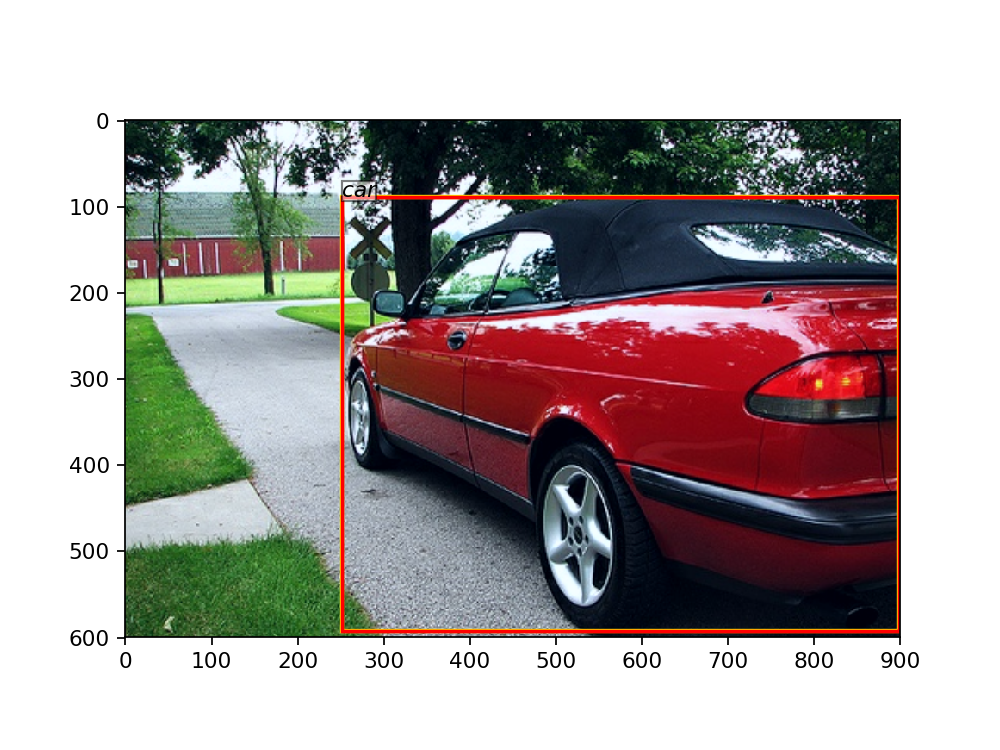

W0705 18:38:49.691178  1104 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [104]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img)
_, bboxes, labels, scale = dataset[1]

for i in range(len(bboxes)):
    y1 = bboxes[i][0]
    x1 = bboxes[i][1]
    y2 = bboxes[i][2]
    x2 = bboxes[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='yellow', linewidth=2))
    ax.text(x1,y1,VOC_BBOX_LABEL_NAMES[labels[i]],style='italic',bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 0})


gt_sample_roi = loc2bbox(sample_roi, gt_roi_loc)
for i in range(3):
    y1 = gt_sample_roi[i][0]
    x1 = gt_sample_roi[i][1]
    y2 = gt_sample_roi[i][2]
    x2 = gt_sample_roi[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='red', linewidth=1.5))

In [106]:
# ROI losses
n_sample = roi_cls_loc.shape[0]
roi_cls_loc = tf.reshape(roi_cls_loc, [n_sample, -1, 4])
idx_ = [[i, j] for i, j in zip(tf.range(n_sample), tf.constant(gt_roi_label))]
roi_loc = tf.gather_nd(roi_cls_loc, idx_)

<IPython.core.display.Javascript object>


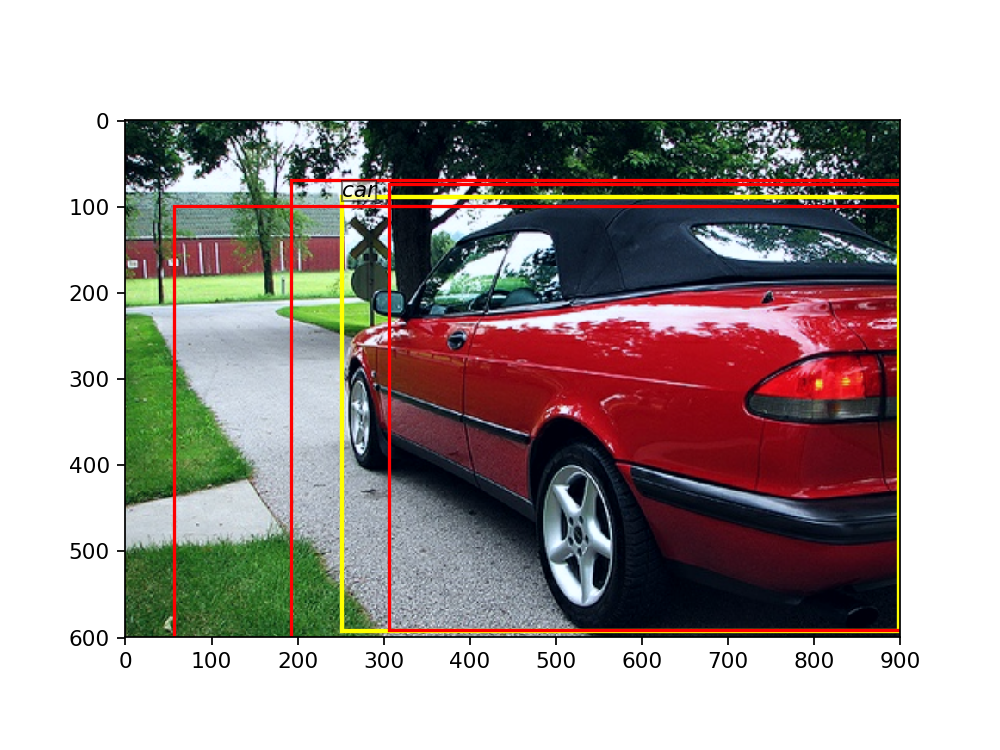

W0705 18:42:52.381001  1104 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [109]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img)
_, bboxes, labels, scale = dataset[1]

for i in range(len(bboxes)):
    y1 = bboxes[i][0]
    x1 = bboxes[i][1]
    y2 = bboxes[i][2]
    x2 = bboxes[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='yellow', linewidth=2))
    ax.text(x1,y1,VOC_BBOX_LABEL_NAMES[labels[i]],style='italic',bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 0})


modified_sample_roi = loc2bbox(sample_roi, roi_loc.numpy())
for i in range(3):
    y1 = modified_sample_roi[i][0]
    x1 = modified_sample_roi[i][1]
    y2 = modified_sample_roi[i][2]
    x2 = modified_sample_roi[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='red', linewidth=1.5))

In [117]:
prob = tf.nn.softmax(roi_score, axis=-1)
prob = prob.numpy()
roi_cls_loc = roi_cls_loc.numpy()
roi_cls_loc = roi_cls_loc.reshape(-1, 21, 4)  # 128, 21, 4

In [131]:
sum(tf.cast(roi_score>0, dtype=tf.int32))

<tf.Tensor: shape=(21,), dtype=int32, numpy=
array([  0,   0,   0,   0,   0,   0,   0, 128,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0])>

In [137]:
modi_roi_bboxes = []
modi_roi_labels = []
modi_roi_scores = []

In [138]:
for label_index in range(1, 21):

    cls_bbox = loc2bbox(sample_roi, roi_cls_loc[:, label_index, :])
    # clip bounding box
    cls_bbox[:, 0::2] = tf.clip_by_value(cls_bbox[:, 0::2], clip_value_min=0, clip_value_max=img_size[0])
    cls_bbox[:, 1::2] = tf.clip_by_value(cls_bbox[:, 1::2], clip_value_min=0, clip_value_max=img_size[1])
    cls_prob = prob[:, label_index]

    mask = cls_prob > 0.05
    cls_bbox = cls_bbox[mask]
    cls_prob = cls_prob[mask]
    keep = tf.image.non_max_suppression(cls_bbox, cls_prob, max_output_size=-1, iou_threshold=0.5)

    if len(keep) > 0:
        modi_roi_bboxes.append(cls_bbox[keep.numpy()])
        # The labels are in [0, self.n_class - 2].
        modi_roi_labels.append((label_index - 1) * np.ones((len(keep),)))
        modi_roi_scores.append(cls_prob[keep.numpy()])
if len(bboxes) > 0:
    modi_roi_bboxes = np.concatenate(modi_roi_bboxes, axis=0).astype(np.float32)
    modi_roi_labels = np.concatenate(modi_roi_labels, axis=0).astype(np.float32)
    modi_roi_scores = np.concatenate(modi_roi_scores, axis=0).astype(np.float32)

In [140]:
modi_roi_labels

array([6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6.], dtype=float32)

In [135]:
VOC_BBOX_LABEL_NAMES[6]

'car'

<IPython.core.display.Javascript object>


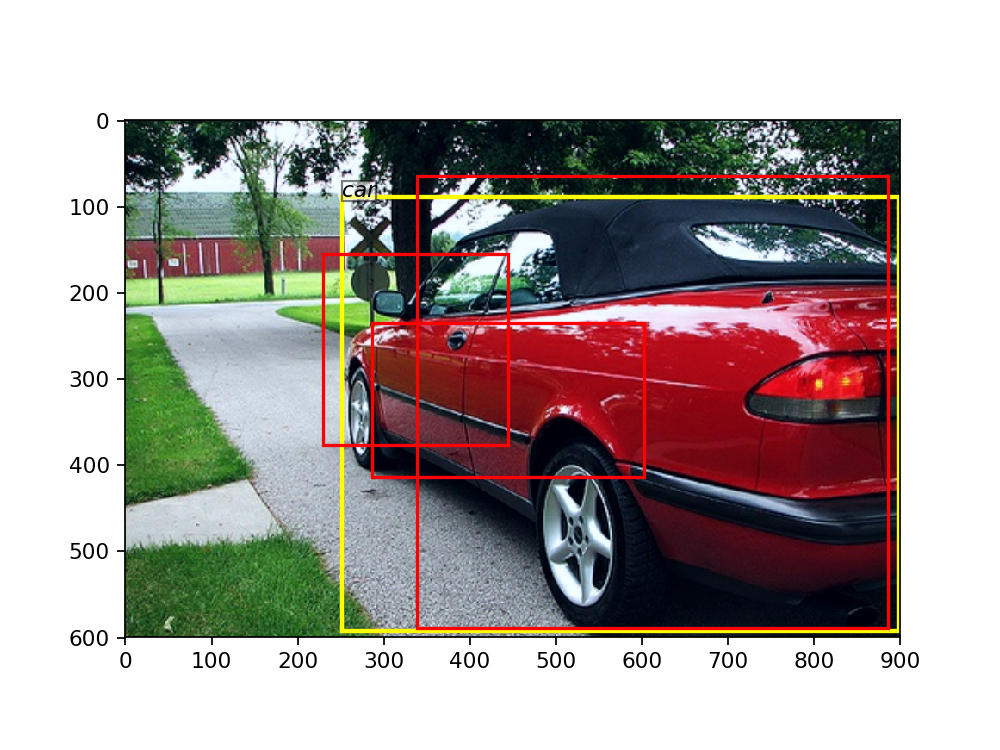

W0705 18:52:29.252390  1104 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [145]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img)
_, bboxes, labels, scale = dataset[1]

for i in range(len(bboxes)):
    y1 = bboxes[i][0]
    x1 = bboxes[i][1]
    y2 = bboxes[i][2]
    x2 = bboxes[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='yellow', linewidth=2))
    ax.text(x1,y1,VOC_BBOX_LABEL_NAMES[labels[i]],style='italic',bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 0})

for i in range(3):
    y1 = modi_roi_bboxes[i][0]
    x1 = modi_roi_bboxes[i][1]
    y2 = modi_roi_bboxes[i][2]
    x2 = modi_roi_bboxes[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='red', linewidth=1.5))